<a href="https://colab.research.google.com/github/sivaharitha-s/Deepfake_detection/blob/main/Deepfake_detection_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import pandas as pd
import os
import zipfile
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:
import os
os.makedirs('/content/styleGAN', exist_ok=True)

In [4]:
import zipfile

zip_path = '/content/drive/MyDrive/StyleGAN.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/styleGAN')

In [5]:
base_dir = '/content/styleGAN/StyleGAN/fake'

original_fake_paths = []

for dirname, _, filenames in tqdm(os.walk(base_dir)):
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.png')):
            original_fake_paths.append([os.path.join(dirname, filename), filename])

print(f"Total fake images found: {len(original_fake_paths)}")

0it [00:00, ?it/s]

Total fake images found: 70000


In [6]:
save_dir = '/content/tmp/fake/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

fake_paths = [os.path.join(save_dir, filename) for _, filename in original_fake_paths]

for path, filename in tqdm(original_fake_paths):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    cv2.imwrite(os.path.join(save_dir, filename), img)

  0%|          | 0/70000 [00:00<?, ?it/s]

In [7]:
train_fake_paths, test_fake_paths = train_test_split(fake_paths, test_size=5000, random_state=2019)

fake_train_df = pd.DataFrame(train_fake_paths, columns=['filename'])
fake_train_df['class'] = 'FAKE'

fake_test_df = pd.DataFrame(test_fake_paths, columns=['filename'])
fake_test_df['class'] = 'FAKE'

print("Train dataframe shape:", fake_train_df.shape)
print("Test dataframe shape:", fake_test_df.shape)

Train dataframe shape: (65000, 2)
Test dataframe shape: (5000, 2)


In [8]:
import os
os.makedirs('/content/celebA', exist_ok=True)

In [9]:
import zipfile

zip_path = '/content/drive/MyDrive/CelebA.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/celebA')

In [10]:
real_dir = '/content/celebA/CelebA/real'
real_save_dir = '/content/tmp/real/'

if not os.path.exists(real_save_dir):
    os.makedirs(real_save_dir)

real_image_paths = []
for filename in tqdm(os.listdir(real_dir)):
    if filename.lower().endswith(('.jpg', '.png')):
        path = os.path.join(real_dir, filename)
        real_image_paths.append(path)


        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(os.path.join(real_save_dir, filename), img)

real_df = pd.DataFrame(real_image_paths, columns=['filename'])
real_df['class'] = 'REAL'

  0%|          | 0/70000 [00:00<?, ?it/s]

In [11]:
from sklearn.model_selection import train_test_split

real_train_df, real_test_df = train_test_split(real_df, test_size=5000, random_state=2019)

print("Train dataframe shape:", real_train_df.shape)
print("Test dataframe shape:", real_test_df.shape)

Train dataframe shape: (65000, 2)
Test dataframe shape: (5000, 2)


In [12]:
train_df = pd.concat([real_train_df, fake_train_df]).reset_index(drop=True)
test_df = pd.concat([real_test_df, fake_test_df]).reset_index(drop=True)

print("Combined train dataframe shape:", train_df.shape)
print("Combined test dataframe shape:", test_df.shape)

Combined train dataframe shape: (130000, 2)
Combined test dataframe shape: (10000, 2)


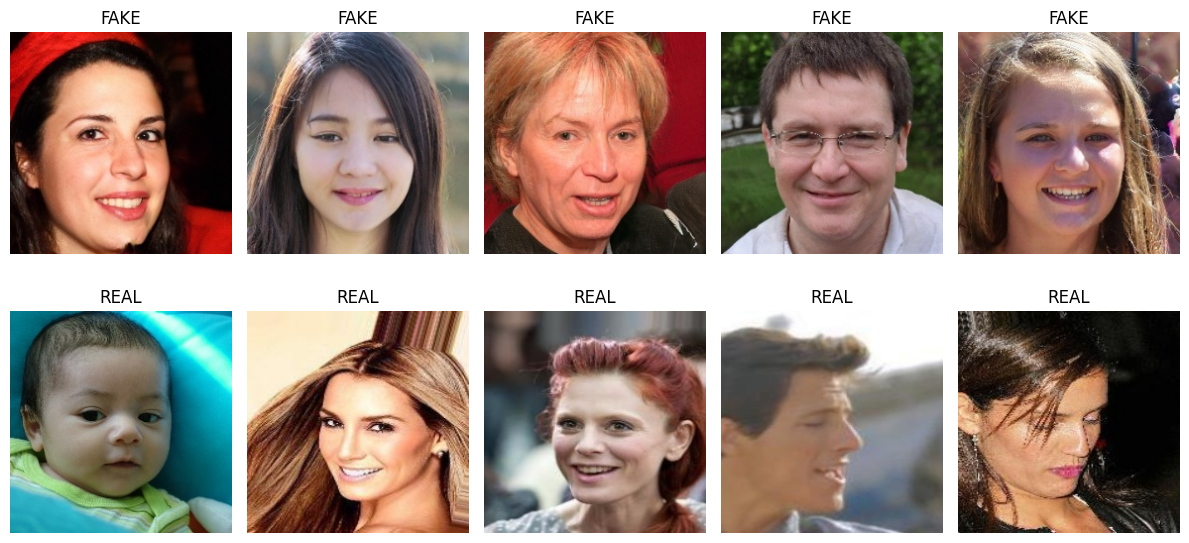

In [18]:
import matplotlib.pyplot as plt
import cv2
import os

fake_dir = '/content/tmp/fake/'
real_dir = '/content/tmp/real/'

fake_images = sorted(os.listdir(fake_dir))[:5]
real_images = sorted(os.listdir(real_dir))[:5]

plt.figure(figsize=(12, 6))

for i, img_name in enumerate(fake_images):
    img_path = os.path.join(fake_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("FAKE")
    plt.axis("off")

for i, img_name in enumerate(real_images):
    img_path = os.path.join(real_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.title("REAL")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    AveragePooling2D, GlobalAveragePooling2D,
    Dense, Concatenate, Dropout
)
from tensorflow.keras.optimizers import Adam


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 104000 validated image filenames belonging to 2 classes.
Found 26000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Dense, Concatenate, Dropout, RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ---- Dense Block ----
def dense_block(x, num_layers, growth_rate):
    """Dense block with concatenated feature maps"""
    for i in range(num_layers):
        bn = BatchNormalization()(x)
        relu = Activation('relu')(bn)
        conv = Conv2D(4 * growth_rate, (1, 1), padding='same', use_bias=False)(relu)
        bn = BatchNormalization()(conv)
        relu = Activation('relu')(bn)
        conv = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(relu)
        x = Concatenate()([x, conv])
    return x

# ---- Transition Layer ----
def transition_layer(x, reduction):
    """Reduce feature map dimensions"""
    bn = BatchNormalization()(x)
    relu = Activation('relu')(bn)
    num_filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    conv = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(relu)
    avg_pool = AveragePooling2D((2, 2), strides=2)(conv)
    return avg_pool

def build_densenet121_scratch(input_shape=(224, 224, 3), num_classes=1,
                               growth_rate=32, reduction=0.5, use_augmentation=True):
    input_tensor = Input(shape=input_shape)

    # Data augmentation
    x = input_tensor
    if use_augmentation:
        x = RandomFlip("horizontal")(x)
        x = RandomRotation(0.05)(x)
        x = RandomZoom(0.05)(x)

    # Initial Conv + MaxPooling
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Blocks + Transition Layers
    x = dense_block(x, 6, growth_rate)
    x = transition_layer(x, reduction)
    x = dense_block(x, 12, growth_rate)
    x = transition_layer(x, reduction)
    x = dense_block(x, 24, growth_rate)
    x = transition_layer(x, reduction)
    x = dense_block(x, 16, growth_rate)

    # Final layers
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='sigmoid', name='predictions')(x)

    model = Model(inputs=input_tensor, outputs=output, name='DenseNet121_Scratch')
    return model

# ---- Build model ----
model = build_densenet121_scratch(input_shape=(224, 224, 3), num_classes=1, use_augmentation=True)

# ---- Compile model ----
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()



Building model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Model Summary:


Model: "DenseNet121_Transfer_Deepfake"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ random_zoom[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],    

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'model.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

history_step1 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=10,
    callbacks=[checkpoint]
)

In [ ]:
print("Loading weights...")
model.load_weights('/content/drive/MyDrive/model (1).h5')
print("Weights loaded successfully!")

Loading weights...
Weights loaded successfully!


In [ ]:
print("Unfreezing all layers...")
for layer in model.layers:
    layer.trainable = True
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

checkpoint_ft = ModelCheckpoint(
    '/content/drive/MyDrive/model_finetuned.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# Start fine-tuning
print("Starting fine-tuning...")
history_step2 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=3,
    callbacks=[checkpoint_ft]
)

print("Fine-tuning completed!")

In [ ]:
import cv2
import numpy as np
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

image_path = '/content/drive/MyDrive/Screenshot 2025-10-13 213907.png'
img = preprocess_image(image_path)
pred = model.predict(img)[0][0]

if pred > 0.5:
    print("Prediction: REAL")
else:
    print("Prediction: FAKE")

print("Prediction score:", pred)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/model_finetuned.h5')
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [ ]:
train_loss, train_acc = model.evaluate(train_gen, steps=len(train_gen), verbose=1)
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")


1625/1625 ━━━━━━━━━━━━━━━━━━━━ 439s 270ms/step - accuracy: 0.9866 - loss: 0.0387
Train Accuracy: 98.68%
Train Loss: 0.0379


In [ ]:
test_loss, test_acc = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 273ms/step - accuracy: 0.9964 - loss: 0.0104
Test Accuracy: 98.84%
Test Loss: 0.0345
